**K-Nearest Neighbors (KNN)**

KNN is a non-parametric, distance-based algorithm that classifies a new sample by considering the majority class among its K nearest neighbors in the feature space. Since EEG data often contains complex, non-linear patterns, KNN can be useful in capturing similarities between subjects with Schizophrenia and healthy controls.

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.3 MB/s eta 0:00:00


In [2]:
import numpy as np

In [3]:
# Load the data from drive
data_array = np.load('/content/drive/My Drive/data_array.npy')
label_array = np.load('/content/drive/My Drive/label_array.npy')
group_array = np.load('/content/drive/My Drive/group_array.npy')
features_array = np.load('/content/drive/My Drive/features_array.npy')

print(data_array.shape, label_array.shape, group_array.shape,features_array.shape)

(6843, 19, 1250) (6843,) (6843,) (6843, 551)


# ML model

In [4]:
!pip install scikit-learn

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
# Define KNN classifier
knn = KNeighborsClassifier()

# Define Group K-Fold
gkf = GroupKFold(n_splits=5)

# Define pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', knn)
])

# Define hyperparameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],  # Test different k values
    'knn__weights': ['uniform', 'distance'],  # Weighting method
    'knn__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

# Perform Grid Search with GroupKFold Cross-Validation
gscv = GridSearchCV(pipe, param_grid, cv=gkf, n_jobs=-1, verbose=1)

# Train model
gscv.fit(features_array, label_array, groups=group_array)
best_model = gscv.best_estimator_

# Print best parameters and score
print("Best Parameters:", gscv.best_params_)
print("Best Score:", gscv.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'knn__n_neighbors': 11, 'knn__p': 2, 'knn__weights': 'uniform'}
Best Score: 0.6021955490236988


# Classification report and Confusion matrix  

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60      3183
           1       0.64      0.57      0.60      3660

    accuracy                           0.60      6843
   macro avg       0.60      0.60      0.60      6843
weighted avg       0.61      0.60      0.60      6843



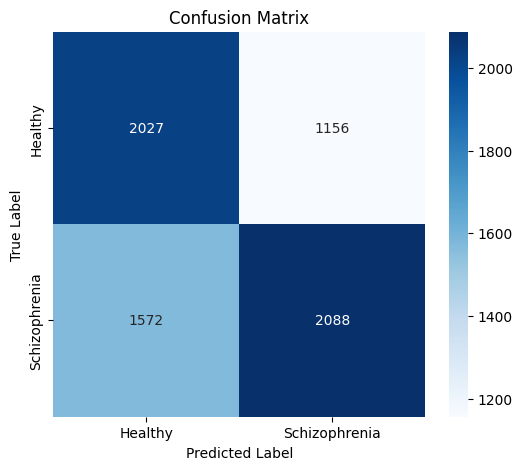

In [7]:
# Initialize arrays for storing results
y_true_all = []
y_pred_all = []

# Perform GroupKFold cross-validation manually with the best model
for train_idx, test_idx in gkf.split(features_array, label_array, groups=group_array):
    # Split data
    X_train, X_test = features_array[train_idx], features_array[test_idx]
    y_train, y_test = label_array[train_idx], label_array[test_idx]

    # Fit the best model on training data
    best_model.fit(X_train, y_train)

    # Predict on test data
    y_pred = best_model.predict(X_test)

    # Store true and predicted labels
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Compute classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all))

# Compute confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Schizophrenia"], yticklabels=["Healthy", "Schizophrenia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()